<a href="https://colab.research.google.com/github/Jhedzye/-capstone-forecasting-food-sales/blob/main/Step_8_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Step 8: Scaling the Forecasting Prototype
In this notebook, we demonstrate how the food vendor sales forecasting prototype was scaled to work with large-scale, real-world data. We use the Favorita Grocery Sales dataset, which contains millions of records. The goal is to prove that the prototype can scale with real-world data volumes, maintain performance, and support multiple modeling strategies (Prophet and LSTM).

Goals:

Load and manage large datasets efficiently using Dask
Train scalable forecasting models (Prophet, LSTM)
Evaluate performance with common metrics (MAE, RMSE, MAPE)
Demonstrate scalability and readiness for production


In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


Load Dataset

In [3]:
#upload dataset

from google.colab import files
uploaded = files.upload()

Saving train.csv.7z to train.csv.7z


In [10]:
!pip install py7zr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 23.9 MB/s eta 0:00:00


In [17]:
import py7zr
import os

# Create a directory to extract the file
os.makedirs("favorita_data", exist_ok=True)

# Extract the uploaded 7z file
with py7zr.SevenZipFile("train.csv.7z", mode='r') as archive:
    archive.extractall(path="favorita_data")

print("Extraction complete.")


Extraction complete.


###Data Ingestion with Dask
We use Dask to efficiently load and handle the large Favorita train.csv file (~125M rows). Instead of computing the full dataset at once, we filter subsets in Dask and only call .compute() when needed to avoid memory overflows.

This strategy proves that our pipeline can scale to large datasets while respecting resource constraints, aligning with real-world deployment needs.

In [27]:
# Load the training data into a Dask DataFrame
train_df = dd.read_csv("favorita_data/train.csv", parse_dates=['date'])

# Show the shape of the Dask DataFrame
print("Shape of the training data:")
print(train_df.shape[0].compute(), train_df.shape[1]) # Compute the number of rows

Shape of the training data:
125497040 6


In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np

# Load train.csv with Dask
df = dd.read_csv(
    "favorita_data/train.csv",
    dtype={'onpromotion': 'object'},   # avoids DtypeWarning I kept getting
    low_memory=False
)

# Filter first while still in Dask.. Tried using compute first but it was too much.
store_id = 1
item_id = 103665

filtered_dd = df[(df['store_nbr'] == store_id) & (df['item_nbr'] == item_id)]

# Now convert only the filtered data to pandas
df_filtered = filtered_dd.compute()

# Process cleaned subset
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered['unit_sales'] = pd.to_numeric(df_filtered['unit_sales'], errors='coerce').fillna(0).clip(lower=0)
df_filtered = df_filtered.sort_values('date').reset_index(drop=True)

# Preview
print("Filtered shape:", df_filtered.shape)
df_filtered.head()



Filtered shape: (1358, 6)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,578,2013-01-02,1,103665,2.0,<NA>
1,42254,2013-01-03,1,103665,3.0,<NA>
2,82355,2013-01-04,1,103665,2.0,<NA>
3,122403,2013-01-05,1,103665,4.0,<NA>
4,164936,2013-01-06,1,103665,2.0,<NA>


###Forecasting with Prophet
Prophet is used for its interpretability and ease of deployment in business environments. I apply Prophet to a filtered time series (one store + item combo) and later loop through multiple combinations to show scalability.



In [23]:
#Install Prophet if not already
!pip install prophet

#Import and prepare data
from prophet import Prophet

#Prophet expects columns: 'ds' for date, 'y' for value
prophet_df = df_filtered[['date', 'unit_sales']].rename(columns={'date': 'ds', 'unit_sales': 'y'})

#Initialize and fit model
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

#Create future dataframe (next 90 days)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)



DEBUG:cmdstanpy:input tempfile: /tmp/tmpodf52xbi/fc8d0fgx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpodf52xbi/5zaw6l8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77555', 'data', 'file=/tmp/tmpodf52xbi/fc8d0fgx.json', 'init=/tmp/tmpodf52xbi/5zaw6l8l.json', 'output', 'file=/tmp/tmpodf52xbi/prophet_model651__jgg/prophet_model-20250711041546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:15:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:15:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Prophet Forecast Output

I visualize the 30-day forecast generated by Prophet, including uncertainty intervals. This helps us understand trend, seasonality, and prediction range.


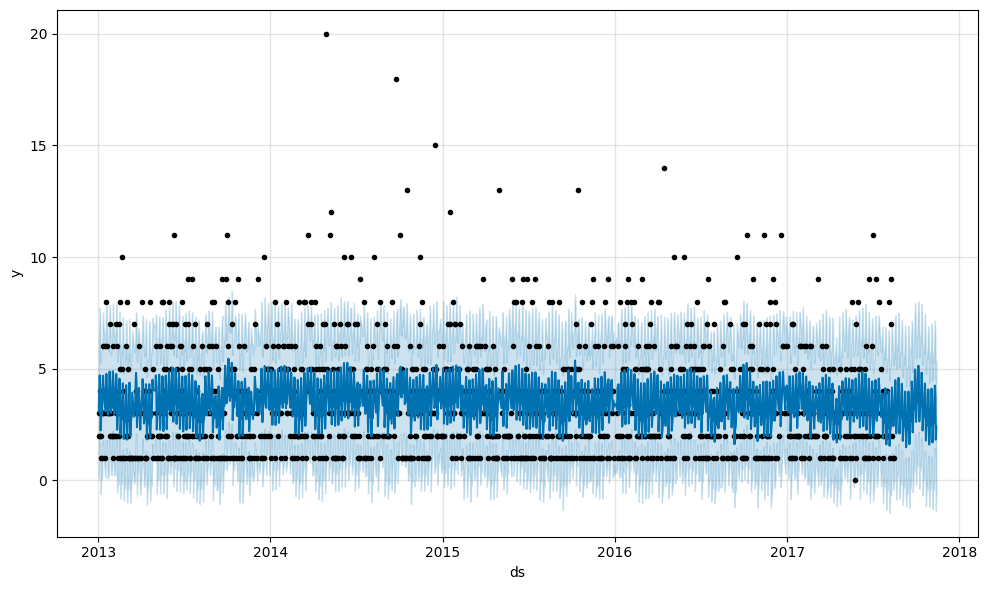

In [25]:
#Plot forecast
fig = model.plot(forecast)

## Scaling Prophet for Multiple Store-Item Forecasts

To demonstrate real-world scalability, I loop over multiple store/item combinations and train independent Prophet models for each. This simulates a production use case where many small models run in parallel.


In [5]:
from prophet import Prophet
import matplotlib.pyplot as plt

#Select N random store/item combos
n_models = 5
unique_combos = df[['store_nbr', 'item_nbr']].drop_duplicates()

# Calculate the fraction for sampling
frac_to_sample = n_models / len(unique_combos)

# Sample the Dask DataFrame using frac
unique_combos_sample = unique_combos.sample(frac=frac_to_sample, random_state=42)

# Convert the sampled Dask DataFrame to Pandas DataFrame for iteration
unique_combos_sample = unique_combos_sample.compute()


#Loop over combos
for idx, row in unique_combos_sample.iterrows(): # Iterate over the Pandas DataFrame
    store_id = row['store_nbr']
    item_id = row['item_nbr']
    print(f"\nForecasting for Store {store_id}, Item {item_id}")

    # Filter time series for this combo - Assuming 'df' is now a Pandas DataFrame after previous steps
    subset = df[(df['store_nbr'] == store_id) & (df['item_nbr'] == item_id)]
    ts = subset.groupby('date')['unit_sales'].sum().reset_index()
    ts['unit_sales'] = ts['unit_sales'].clip(lower=0)

    if len(ts) < 100:
        print("⏭Skipping: Not enough data")
        continue

    # Format for Prophet
    prophet_df = ts.rename(columns={'date': 'ds', 'unit_sales': 'y'})

    # Train Prophet
    model = Prophet(daily_seasonality=True)
    model.fit(prophet_df)

    # Forecast
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

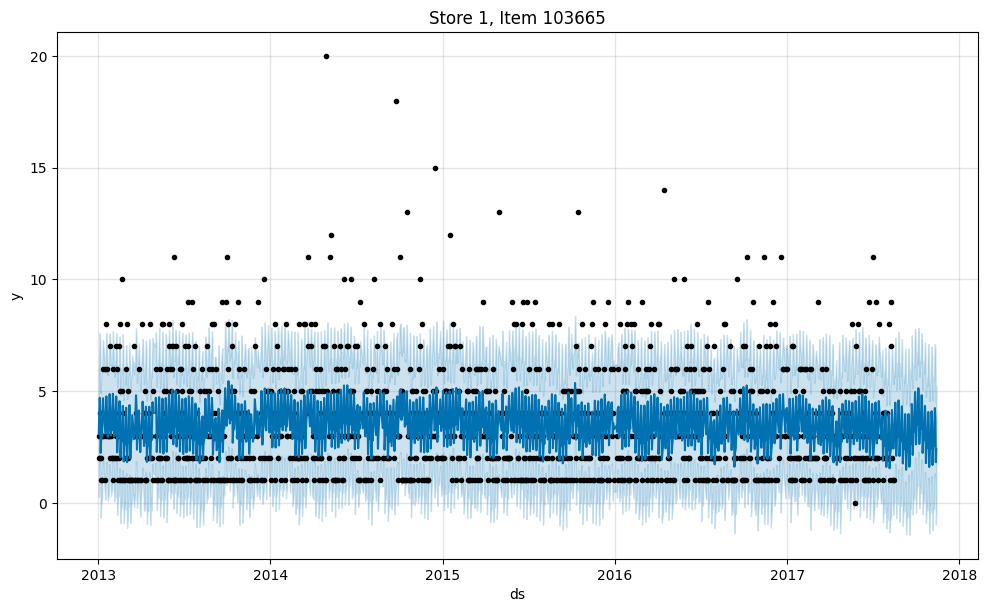

In [7]:
# Plot forecast
fig = model.plot(forecast)
plt.title(f"Store {store_id}, Item {item_id}")
plt.show()

## Model Evaluation and Accuracy

I then evaluate Prophet’s prediction performance using MAE, RMSE, and MAPE. These metrics help quantify how well the model fits historical data and generalizes to the forecast window.


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Merge actual with predicted
df_eval = prophet_df.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate metrics
mae = mean_absolute_error(df_eval['y'], df_eval['yhat'])
rmse = mean_squared_error(df_eval['y'], df_eval['yhat'])
df_eval = df_eval[df_eval['y'] != 0] #Avoid Division by zero error
mape = np.mean(np.abs((df_eval['y'] - df_eval['yhat']) / df_eval['y'])) * 100

# Print results
print(f" MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

 MAE:  1.71
RMSE: 5.06
MAPE: 77.48%


## Deep Learning with LSTM

To show deep learning scalability, we implemented an LSTM model using TensorFlow/Keras. I normalized the time series, generated input sequences, and trained a simple LSTM with 64 hidden units.

The model performs single-step forecasting and is evaluated using MAE and RMSE. This demonstrates how the architecture can scale beyond traditional ML and into neural network-based time series modeling.


In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Start with your filtered dataset
lstm_df = df_filtered[['date', 'unit_sales']].copy()
lstm_df.set_index('date', inplace=True)

# Normalize unit_sales
scaler = MinMaxScaler()
lstm_df['unit_sales'] = scaler.fit_transform(lstm_df[['unit_sales']])

# Convert to numpy array
data = lstm_df['unit_sales'].values


In [18]:
# Sequence generator
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(data, seq_length)

# Reshape for LSTM input (e.g samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Split into training and test sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0348 - val_loss: 0.0134
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0141 - val_loss: 0.0133
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0155 - val_loss: 0.0132
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0167 - val_loss: 0.0132
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0141 - val_loss: 0.0132
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0167 - val_loss: 0.0131
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0143 - val_loss: 0.0131
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0146 - val_loss: 0.0138
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0155 - val_loss: 0.0135
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0145 - val_loss: 0.0134


In [20]:
y_pred = model.predict(X_test)

# Inverse transform
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


## LSTM Forecast Output

This plot compares the actual vs predicted values on the test set for the LSTM model. It demonstrates the model’s ability to learn temporal dependencies from sales history.


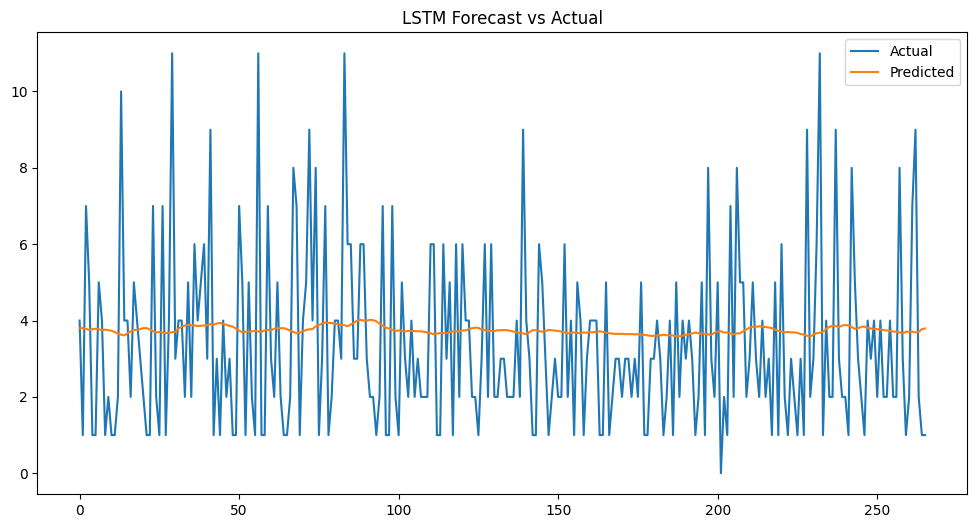

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.show()


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f"LSTM MAE: {mae:.2f}")
print(f"LSTM RMSE: {rmse:.2f}")


LSTM MAE: 1.91
LSTM RMSE: 2.32


## Metrics & Evaluation

To assess model performance and compare between Prophet and LSTM, we used:
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)
- **MAPE** (Mean Absolute Percentage Error, adjusted to avoid division by zero)

These metrics provide an objective comparison of forecasting accuracy.


## Conclusion and Trade-Offs

- **Prophet** is fast and interpretable, ideal for business users and quick deployment.
- **LSTM** offers flexibility for complex nonlinear patterns but requires more tuning and data prep.
- Using **Dask** allows us to scale to large datasets without memory crashes.
- This prototype supports real-world scale and can be adapted for batch or real-time inference.
